# Intent Classification Problem

In [1]:
import json
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer
import re
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

### Data Preparation

The data is saved in json file. The file is read using json reader. 
All the unique class combination is then read and numpy.random.choice function is used to choose "K" random classes.

#### 1. Data Cleaning
The data cleaning is done by removing all punctuation and special characters(if any) then I tokenized the sentences into words. After this, words are converted to lower case.

#### 2. Encoding
a. Input encoding
After cleaning the words in sentences, these are then converted into indexes using the Tokenizer() utility of Keras. This class allows to vectorize a text corpus, by turning each text into either a sequence of integers. 
b. Output Encoding
The output class is then convert into k categories and then used one hot encoding with with "k" dimension.

#### 3. Training, Validation and Test Data
100 * k  train data samples, 20 * k validation data samples, and 30* k  test samples.

In [2]:
class intent_classification:
    def __init__(self, filename):
        self.x_train = None
        self.y_train = None
        self.x_test = None
        self.y_test = None
        self.x_val = None
        self.y_val = None
        self.num_words = None
        self.max_len = None
        self.num_of_class = None
        self.class_list = None
        self.word_tokenizer = None
        self.filename = filename
        self.model = None
        self.model_name = None
        
    def load_data(self, num_of_class):
        f = open(self.filename,)
        self.num_of_class = num_of_class
        data = json.load(f)

        train_all_data = pd.DataFrame(data['train'],columns = ["sentence","class_name"])
        val_all_data = pd.DataFrame(data['val'],columns = ["sentence","class_name"])
        test_all_data = pd.DataFrame(data['test'],columns = ["sentence","class_name"])

        class_name = train_all_data.class_name.unique()
        self.class_list = np.random.choice(class_name, self.num_of_class, replace=False)

        one_hot = OneHotEncoder(sparse = False)
        one_hot.fit(self.class_list.reshape(-1,1))

        train = train_all_data[train_all_data['class_name'].isin(self.class_list)].reset_index(drop=True)
        test = test_all_data[test_all_data['class_name'].isin(self.class_list)].reset_index(drop=True)
        val = val_all_data[val_all_data['class_name'].isin(self.class_list)].reset_index(drop=True)

        x_train = clean_sentence(list(train["sentence"]))
        self.max_len = len(max(x_train, key = len))
        self.word_tokenizer = create_tokenizer(x_train)
        self.num_words = len(self.word_tokenizer.word_index) + 1

        self.x_train = self.encode_data(x_train)
        self.y_train = one_hot.transform(train["class_name"].to_numpy().reshape(-1,1))

        self.x_test = self.encode_data(clean_sentence(list(test["sentence"])))
        self.y_test = one_hot.transform(test["class_name"].to_numpy().reshape(-1,1))

        self.x_val = self.encode_data(clean_sentence(list(val["sentence"])))  
        self.y_val = one_hot.transform(val["class_name"].to_numpy().reshape(-1,1))

    def encode_data(self,data):
        data_encoded = self.word_tokenizer.texts_to_sequences(data)
        data_padded = pad_sequences(data_encoded, maxlen = self.max_len, padding = "post")
        return data_padded
    
    def create_model(self,model_name):
        self.model_name = model_name
        self.model = Sequential()
        self.model.add(Embedding(self.num_words, 128, input_length = self.max_len, trainable = False))
        self.model.add(Bidirectional(LSTM(128)))
        self.model.add(Dense(32, activation = "relu"))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(20, activation = "softmax"))
    
    def compile_model(self, loss_ = "categorical_crossentropy", optimizer_ = "adam", metrics_ = ["accuracy"]):
        self.model.compile(loss = loss_, optimizer= optimizer_, metrics=metrics_)
        self.model.summary()
    
    def fit_model(self, num_of_epochs = 100, batch_size_ = 32):
        checkpoint = ModelCheckpoint(self.model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        hist = self.model.fit(self.x_train, self.y_train, epochs = num_of_epochs, batch_size = batch_size_, validation_data = (self.x_val, self.y_val), callbacks = [checkpoint])
        return hist
    
    def class_category_names(self):
        return self.class_list
    
    def print_data_params(self):
        print("Classes chosen :", self.class_list)
        print("training data dims:",self.x_train.shape)
        print("validation data dims:",self.x_val.shape)
        print("test data dims:",self.x_test.shape)
        print("num of words in tokenizer",self.num_words)

In [3]:
def clean_sentence(data):
    words = []
    for sentence in data:
        cleanword = re.sub(r'[^ a-z A-Z 0-9]', " ", sentence)
        w = word_tokenize(cleanword)
        words.append([i.lower() for i in w])
    return words

def create_tokenizer(words, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'):
    token = Tokenizer(filters = filters)
    token.fit_on_texts(words)
    return token

In [4]:
obj = intent_classification('data_full.json')
num_of_classes = 20
obj.load_data(num_of_classes)
obj.print_data_params()

Classes chosen : ['accept_reservations' 'restaurant_reviews' 'transactions' 'credit_score'
 'find_phone' 'smart_home' 'cancel_reservation' 'goodbye'
 'reminder_update' 'reminder' 'timer' 'direct_deposit'
 'credit_limit_change' 'damaged_card' 'pin_change' 'gas' 'are_you_a_bot'
 'calendar_update' 'rollover_401k' 'thank_you']
training data dims: (2000, 20)
validation data dims: (400, 20)
test data dims: (600, 20)
num of words in tokenizer 1345


### Model
Bidirectional LSTM is used as the model. 

The loss is categorical_crossentropy" with adam optimizer.
Dropout layer is added to avoid overfitting. 
The number of epochs is 100 and batch size of 32
Training loss: 0.1735 and training accuracy: 94.50% 
The validation loss: 1.1451 and validation accuracy: 87.00%

In [5]:
model_name = 'model.h5'
obj.create_model(model_name)
obj.compile_model(loss_ = "categorical_crossentropy", optimizer_ = "adam", metrics_ = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 128)           172160    
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dense (Dense)                (None, 32)                8224      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                660       
Total params: 444,212
Trainable params: 272,052
Non-trainable params: 172,160
_________________________________________________________________


In [6]:
hist = obj.fit_model(num_of_epochs = 100, batch_size_ = 32)

Epoch 1/100
62/63 [============================>.] - ETA: 0s - loss: 2.9892 - accuracy: 0.0620
Epoch 00001: val_loss improved from inf to 2.96199, saving model to model.h5
63/63 [==============================] - 2s 26ms/step - loss: 2.9889 - accuracy: 0.0630 - val_loss: 2.9620 - val_accuracy: 0.0800
Epoch 2/100
62/63 [============================>.] - ETA: 0s - loss: 2.9083 - accuracy: 0.0968
Epoch 00002: val_loss improved from 2.96199 to 2.83180, saving model to model.h5
63/63 [==============================] - 1s 13ms/step - loss: 2.9081 - accuracy: 0.0965 - val_loss: 2.8318 - val_accuracy: 0.0900
Epoch 3/100
60/63 [===========================>..] - ETA: 0s - loss: 2.7218 - accuracy: 0.1401
Epoch 00003: val_loss improved from 2.83180 to 2.55523, saving model to model.h5
63/63 [==============================] - 1s 13ms/step - loss: 2.7157 - accuracy: 0.1420 - val_loss: 2.5552 - val_accuracy: 0.2375
Epoch 4/100
60/63 [===========================>..] - ETA: 0s - loss: 2.4326 - accuracy

Epoch 29/100
61/63 [============================>.] - ETA: 0s - loss: 0.3740 - accuracy: 0.8601
Epoch 00029: val_loss did not improve from 0.58598
63/63 [==============================] - 1s 14ms/step - loss: 0.3762 - accuracy: 0.8595 - val_loss: 0.6191 - val_accuracy: 0.8400
Epoch 30/100
61/63 [============================>.] - ETA: 0s - loss: 0.3948 - accuracy: 0.8530
Epoch 00030: val_loss did not improve from 0.58598
63/63 [==============================] - 1s 14ms/step - loss: 0.3904 - accuracy: 0.8545 - val_loss: 0.6171 - val_accuracy: 0.8275
Epoch 31/100
61/63 [============================>.] - ETA: 0s - loss: 0.4262 - accuracy: 0.8509
Epoch 00031: val_loss did not improve from 0.58598
63/63 [==============================] - 1s 14ms/step - loss: 0.4280 - accuracy: 0.8505 - val_loss: 0.5891 - val_accuracy: 0.8350
Epoch 32/100
61/63 [============================>.] - ETA: 0s - loss: 0.3542 - accuracy: 0.8724
Epoch 00032: val_loss did not improve from 0.58598
63/63 [===============

61/63 [============================>.] - ETA: 0s - loss: 0.1683 - accuracy: 0.9303
Epoch 00058: val_loss did not improve from 0.54530
63/63 [==============================] - 1s 19ms/step - loss: 0.1675 - accuracy: 0.9305 - val_loss: 0.7365 - val_accuracy: 0.8675
Epoch 59/100
61/63 [============================>.] - ETA: 0s - loss: 0.1693 - accuracy: 0.9360
Epoch 00059: val_loss did not improve from 0.54530
63/63 [==============================] - 1s 18ms/step - loss: 0.1696 - accuracy: 0.9360 - val_loss: 0.7923 - val_accuracy: 0.8625
Epoch 60/100
61/63 [============================>.] - ETA: 0s - loss: 0.1744 - accuracy: 0.9319
Epoch 00060: val_loss did not improve from 0.54530
63/63 [==============================] - 1s 19ms/step - loss: 0.1714 - accuracy: 0.9330 - val_loss: 0.5893 - val_accuracy: 0.8725
Epoch 61/100
61/63 [============================>.] - ETA: 0s - loss: 0.2255 - accuracy: 0.9175
Epoch 00061: val_loss did not improve from 0.54530
63/63 [============================

Epoch 88/100
62/63 [============================>.] - ETA: 0s - loss: 0.1219 - accuracy: 0.9572
Epoch 00088: val_loss did not improve from 0.50898
63/63 [==============================] - 1s 19ms/step - loss: 0.1214 - accuracy: 0.9575 - val_loss: 0.6815 - val_accuracy: 0.8725
Epoch 89/100
63/63 [==============================] - ETA: 0s - loss: 0.1162 - accuracy: 0.9490
Epoch 00089: val_loss did not improve from 0.50898
63/63 [==============================] - 1s 19ms/step - loss: 0.1162 - accuracy: 0.9490 - val_loss: 0.6504 - val_accuracy: 0.8800
Epoch 90/100
61/63 [============================>.] - ETA: 0s - loss: 0.1184 - accuracy: 0.9529
Epoch 00090: val_loss did not improve from 0.50898
63/63 [==============================] - 1s 19ms/step - loss: 0.1191 - accuracy: 0.9525 - val_loss: 0.7036 - val_accuracy: 0.8775
Epoch 91/100
62/63 [============================>.] - ETA: 0s - loss: 0.1113 - accuracy: 0.9567
Epoch 00091: val_loss did not improve from 0.50898
63/63 [===============

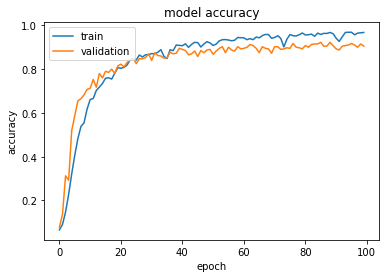

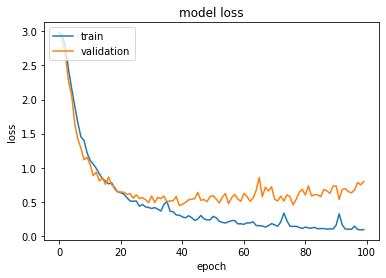

In [6]:
# "Accuracy"
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [7]:
y_pred = np.argmax(model.predict(x_test, verbose=0),axis = 1)
y_true = np.argmax(y_test,axis = 1)

Test data is evaluated using the model and a total test accuracy is 89.83%%%

In [8]:
print("Test accuracy: ",accuracy_score(y_true, y_pred) * 100.0,"%")

Test accuracy:  89.83333333333333 %
